# Credit Scoring - scoring card

### The purpose of this project is to make a PD (default12) model and build scoring card

### Data for this project are simulation data created by Karol Przanowski who is expert in credit scoring. 

#### Data period 1975 - 1987

In [178]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve
from statsmodels.discrete.discrete_model import Logit
from statsmodels.formula.api import logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from matplotlib.ticker import NullLocator, FixedLocator, LogLocator, MultipleLocator
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.base import BaseEstimator, RegressorMixin
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#### Reading data

In [2]:
df = pd.read_sas('train_woe.sas7bdat')
df = df[df['default12'].notna()]
df['n'] = 1
df.columns = [x.lower() for x in df.columns]

In [3]:
df['period'] = df['period'].map(lambda x: str(x).split("'")[1].strip())
df['year'] = df['period'].map(lambda x: x[:4])
df['period'] = df['period'].map(lambda x: int(x))
df_defaults = df[['year','default12','default9','default6','default3']]

In [4]:
defaults = df.groupby(['year'])['default3','default6','default9','default12','n'].sum().sort_values(by='year').reset_index()
defaults['default3p'] = defaults['default3']/defaults['n']
defaults['default6p'] = defaults['default6']/defaults['n']
defaults['default9p'] = defaults['default9']/defaults['n']
defaults['default12p'] = defaults['default12']/defaults['n']

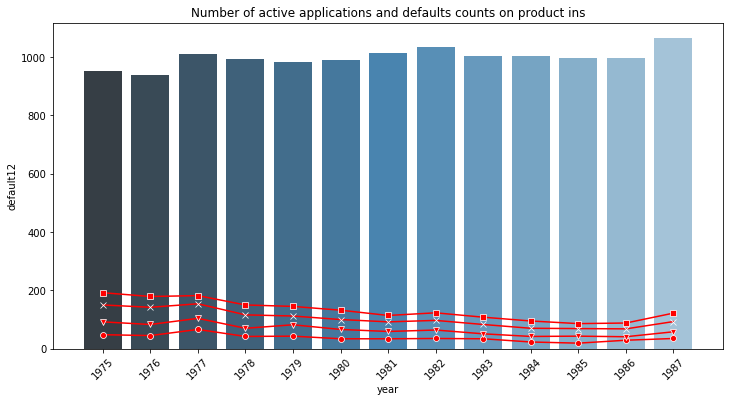

In [5]:
plt.figure(figsize=(12,6))
sns.barplot(x='year', y='n', data=defaults, palette="Blues_d");
plt.xticks(rotation=45);
sns.lineplot(x='year', y='default3', data=defaults, color='red',marker="o");
sns.lineplot(x='year', y='default6', data=defaults, color='red',marker="v");
sns.lineplot(x='year', y='default9', data=defaults, color='red',marker="x");
sns.lineplot(x='year', y='default12', data=defaults, color='red',marker="s");
plt.title("Number of active applications and defaults counts on product ins");

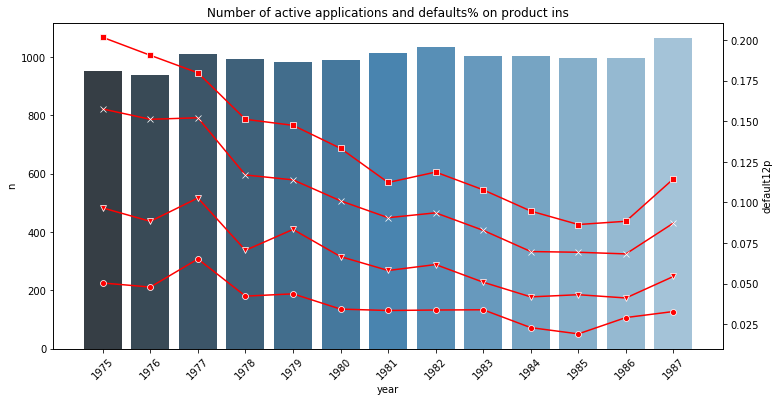

In [6]:
plt.figure(figsize=(12,6))
sns.barplot(x='year', y='n', data=defaults, palette="Blues_d");
plt.xticks(rotation=45);
ax2 = plt.twinx()
sns.lineplot(x='year', y='default3p', data=defaults, color='red',marker="o", ax= ax2);
sns.lineplot(x='year', y='default6p', data=defaults, color='red',marker="v");
sns.lineplot(x='year', y='default9p', data=defaults, color='red',marker="x");
sns.lineplot(x='year', y='default12p', data=defaults, color='red',marker="s");
plt.title("Number of active applications and defaults% on product ins");

In [7]:
to_remove = [   
'default9','default6','aid','cid','default3',
 'cross_response',
 'cross_after_monhs',
 'default_cross3',
 'default_cross6',
 'default_cross9',
 'decision',
 'cross_aid',
 'cross_aid',
 'n'
]

for feat in to_remove:
    if feat in df.columns:
        del df[feat]

In [8]:
print(df['default12'].value_counts())

0.0    11263
1.0     1716
Name: default12, dtype: int64


In [9]:
"Percentage of defaults {}".format(round(df['default12'].value_counts(normalize=True)[1],2))

'Percentage of defaults 0.13'

#### GRP features - features after binning using decision tree

In [10]:
feats_correct = [feat for feat in df.columns if "grp_" in feat]
"Number of features: {}".format(len(feats_correct))

'Number of features: 202'

### Splitting data using time sampling 

In [11]:
def features(feats):
    test = df[df['period']>= 198305].fillna(0)
    train = df[df['period'] < 198305].fillna(0)
    X_train = train[feats]
    X_test = test[feats]
    y_train = train['default12']
    y_test = test['default12']
    return train, test, X_train, X_test, y_train, y_test


def split_and_train(feats):
    train, test, X_train, X_test, y_train, y_test = features(feats)
    #model_rl = Logit(y_train,X_train).fit()
    model_rl = sm.GLM(y_train, X_train,family=sm.families.Binomial()).fit()
    prawd_rl_train = model_rl.predict(X_train)
    prawd_rl = model_rl.predict(X_test)
    
    
    gini_test = 2*roc_auc_score(y_test, prawd_rl)-1
    gini_train = 2*roc_auc_score(y_train, prawd_rl_train)-1
    print("Feats:", len(feats))
    print('gini_test score:', gini_test.round(3))
    print('gini_train score:', gini_train.round(3))
    return gini_test.round(3), gini_train.round(3)

### First model using 202 GRP features

### Gini Test : 0.535

In [12]:
split_and_train(feats_correct)

Feats: 202
gini_test score: 0.535
gini_train score: 0.532


(0.535, 0.532)

### Transformation each category of feature to logi and calculation  statistics like WoE, IV 

In [13]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        train, test, X_train, X_test, y_train, y_test = features(feature)
        lst.append({
            'Feature':feature,
            'Value': val,
            "Condition" : "{} < {} << {}".format(dataset[dataset[feature] == val][feature.replace("grp_","")].min(),feature.replace("grp_",""),dataset[dataset[feature] == val][feature.replace("grp_","")].max()),
            "Max": dataset[dataset[feature] == val][feature.replace("grp_","")].max(),
            "Min": dataset[dataset[feature] == val][feature.replace("grp_","")].min(),
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature],
            "ti": train[train[feature] == val].count()[feature],
            "vi": test[test[feature] == val].count()[feature]
        })
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    

    dset['WoE'] = np.log(dset['Good']/dset['Bad']) - np.log(dset['Good'].sum()/dset['Bad'].sum())
    #Woe = Logit
    dset['Logit'] =  - np.log( dset['Good'] / dset['Bad'] )
    
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) *  dset['WoE']
    dset['ti'] = dset['ti'] / dset['ti'].sum()
    dset['vi'] = dset['vi'] / dset['vi'].sum()
    dset["IS"] = (dset['ti'] - dset['vi']) * np.log((dset['ti'] / dset['vi']))
    dset["KL"] = dset['ti'] - np.log((dset['ti'] / dset['vi']))
    dset = dset.replace({'vi': {np.inf: 0, -np.inf: 0}})
    dset = dset.replace({'KL': {np.inf: 0, -np.inf: 0}})
    
    IV = dset['IV'].sum()
    IS = dset['IS'].sum()
    KL = dset['KL'].sum()
    
    dset = dset.sort_values(by='WoE')

    return dset,dset[['Value','Logit','WoE']], IV, IS, KL

In [14]:
feats = []
information = []
index_stability = []
kulback = []
statistic = pd.DataFrame()


for feat in  feats_correct:
    feats.append(feat)
    stats ,woe, iv, IS, KL = calculate_woe_iv(df, feat, 'default12')
    statistic= statistic.append(stats)
    information.append(iv)
    index_stability.append(IS)
    kulback.append(KL)

    woe_index = dict(zip(woe['Value'],woe['Logit']))
    df['{}_Logit'.format(feat)] = df[feat].map(woe_index)

feature_stat = pd.DataFrame({"Feat":feats,
                  "IV":information,
                    "IS":information,
                    "KL":kulback})

In [15]:
statistic.head(10)

,Feature,Value,Condition,Max,Min,All,Good,Bad,ti,vi,Distr_Good,Distr_Bad,WoE,Logit,IV,IS,KL
1,grp_act12_n_arrears,1.0,0.0 < act12_n_arrears << 0.0,0,0,487,307,180,0.040529,0.032292,0.027257,0.104895,-1.347636,-0.533891,0.104627,0.001871,-0.186667
2,grp_act12_n_arrears,2.0,1.0 < act12_n_arrears << 12.0,12,1,451,316,135,0.041985,0.022161,0.028056,0.078671,-1.031060,-0.850467,0.052187,0.012667,-0.596987
0,grp_act12_n_arrears,3.0,nan < act12_n_arrears << nan,NaN,NaN,12041,10640,1401,0.917486,0.945547,0.944686,0.816434,0.145907,-2.027434,0.018713,0.000845,0.947612
1,grp_act12_n_arrears_days,1.0,0.0 < act12_n_arrears_days << 2.0,2,0,938,623,315,0.082514,0.054453,0.055314,0.183566,-1.199553,-0.681974,0.153846,0.011663,-0.333112
0,grp_act12_n_arrears_days,2.0,nan < act12_n_arrears_days << nan,NaN,NaN,12041,10640,1401,0.917486,0.945547,0.944686,0.816434,0.145907,-2.027434,0.018713,0.000845,0.947612
2,grp_act12_n_good_days,1.0,4.0 < act12_n_good_days << 12.0,12,4,441,275,166,0.036767,0.029126,0.024416,0.096737,-1.376744,-0.504783,0.099567,0.001780,-0.196205
1,grp_act12_n_good_days,2.0,0.0 < act12_n_good_days << 3.0,3,0,497,348,149,0.045747,0.025327,0.030898,0.086830,-1.033271,-0.848256,0.057793,0.012073,-0.545500
0,grp_act12_n_good_days,3.0,nan < act12_n_good_days << nan,NaN,NaN,12041,10640,1401,0.917486,0.945547,0.944686,0.816434,0.145907,-2.027434,0.018713,0.000845,0.947612
1,grp_act3_n_arrears,1.0,0.0 < act3_n_arrears << 3.0,3,0,938,623,315,0.082514,0.054453,0.055314,0.183566,-1.199553,-0.681974,0.153846,0.011663,-0.333112
0,grp_act3_n_arrears,2.0,nan < act3_n_arrears << nan,NaN,NaN,12041,10640,1401,0.917486,0.945547,0.944686,0.816434,0.145907,-2.027434,0.018713,0.000845,0.947612


In [16]:
Logit_feats = [feat for feat in df.columns if "Logit" in feat]
len(Logit_feats)

202

### Model using 202 Logit features 

### Gini Test 0.81

In [17]:
split_and_train(Logit_feats)

Feats: 202
gini_test score: 0.81
gini_train score: 0.758


(0.81, 0.758)

In [18]:
def pre_selection(feats):
    train, test, X_train, X_test, y_train, y_test = features(feats)
    model_rl = sm.GLM(y_train, X_train,family=sm.families.Binomial()).fit()
    prawd_rl_train = model_rl.predict(X_train)
    prawd_rl = model_rl.predict(X_test)
    
    gini_test = 2*roc_auc_score(y_test, prawd_rl)-1
    gini_train = 2*roc_auc_score(y_train, prawd_rl_train)-1
    return gini_test.round(3), gini_train.round(3)

In [19]:
%time
feats = []
ginis_train = []
ginis_test = []

for feat in Logit_feats:
    feats.append(feat)
    gini_test, gini_train = pre_selection(feat)
    ginis_test.append(gini_test)
    ginis_train.append(gini_train)


preselection = pd.DataFrame({"Zmienna":feats,
                             "Gini_train":ginis_train,
                             "Gini_test":ginis_test})

preselection["Ar_diff"] = (np.abs(preselection.Gini_train - preselection.Gini_test)/preselection.Gini_train)
preselection['Feat'] =  preselection['Zmienna'].map(lambda x: x.split("_Logit")[0])



Wall time: 0 ns


In [20]:
preselection = pd.merge(preselection, feature_stat)
preselection_ = preselection.copy()
preselection.shape

(202, 8)

In [21]:
preselection.head(10)

,Zmienna,Gini_train,Gini_test,Ar_diff,Feat,IV,IS,KL
0,grp_act12_n_arrears_Logit,0.107,0.175,0.635514,grp_act12_n_arrears,0.175527,0.175527,0.163958
1,grp_act12_n_arrears_days_Logit,0.107,0.173,0.616822,grp_act12_n_arrears_days,0.172559,0.172559,0.614500
2,grp_act12_n_good_days_Logit,0.109,0.173,0.587156,grp_act12_n_good_days,0.176073,0.176073,0.205907
3,grp_act3_n_arrears_Logit,0.107,0.173,0.616822,grp_act3_n_arrears,0.172559,0.172559,0.614500
4,grp_act3_n_arrears_days_Logit,0.107,0.173,0.616822,grp_act3_n_arrears_days,0.172559,0.172559,0.614500
5,grp_act3_n_good_days_Logit,0.111,0.176,0.585586,grp_act3_n_good_days,0.221456,0.221456,0.199608
6,grp_act6_n_arrears_Logit,0.107,0.173,0.616822,grp_act6_n_arrears,0.172559,0.172559,0.614500
7,grp_act6_n_arrears_days_Logit,0.107,0.173,0.616822,grp_act6_n_arrears_days,0.172559,0.172559,0.614500
8,grp_act6_n_good_days_Logit,0.110,0.175,0.590909,grp_act6_n_good_days,0.198695,0.198695,0.194078
9,grp_act9_n_arrears_Logit,0.107,0.173,0.616822,grp_act9_n_arrears,0.172559,0.172559,0.614500


### Preselection:
###    IV > 0.09
###    Gini Test > 0.1

In [45]:
preselection = preselection[preselection.IV > 0.09]
preselection = preselection[preselection.Gini_test > 0.1]
preselection.shape

(108, 8)

In [24]:
df.period = df.period.map(lambda x: int(x))

In [25]:
df['intercept'] = 1

# Selection 15 best features 

In [79]:

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class):
        self.model_class = model_class
    def fit(self, X, y=None):
        self.model_ = self.model_class(y.values, X)
        self.results_ = self.model_.fit(disp = 0)
    def predict(self, X):
        return self.results_.predict(X)
    
    
sffs = SFS(SMFormulaWrapper(sm.GLM), 
          k_features=(15), 
          forward=True, 
          floating=True,
          n_jobs = -1 ,
          cv=2, verbose=1, scoring = 'roc_auc')

test = df[df.period >= 198305].fillna(0)
train = df[df.period < 198305].fillna(0)
X_train = train[preselection.Zmienna.values]
X_test = test[preselection.Zmienna.values]
y_train = train['default12']
y_test = test['default12']

In [80]:
sffs = sffs.fit(pd.concat([X_train, X_test])[preselection.Zmienna.values], pd.concat([y_train, y_test]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.3s finished
Features: 1/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [81]:
featurest = list(sffs.k_feature_names_)

# Selected 7 features

In [103]:
featurest= [
 'grp_act_call_n_loan_Logit',
 'grp_act_cc_Logit',
 'grp_act_cins_min_seniority_Logit',
 'grp_act_loaninc_Logit',
 'grp_app_igjm_Logit',
 'grp_app_number_of_children_Logit',
 'grp_act_age_Logit']

# Training model 

In [105]:
train, test, X_train, X_test, y_train, y_test = features(np.append('intercept',featurest))
# model_rl = Logit(y_train,X_train).fit()
model_rl = sm.GLM(y_train, X_train,family=sm.families.Binomial()).fit()
prawd_rl_train = model_rl.predict(X_train)
prawd_rl = model_rl.predict(X_test)
prawd_rl_train = model_rl.predict(X_train)
prawd_rl = model_rl.predict(X_test)

print("************ Model Params ************")
print(model_rl.params)


gini_test = 2*roc_auc_score(y_test, prawd_rl)-1
gini_train = 2*roc_auc_score(y_train, prawd_rl_train)-1
print("Feats:", len(feats))
print("************ Gini ************")
print('gini_test score:', gini_test.round(3))
print('gini_train score:', gini_train.round(3))

VIF_ = pd.DataFrame([variance_inflation_factor(df[np.append('default12',np.append('intercept',featurest))].values, i) for i in range(df[np.append('default12',np.append('intercept',featurest)) ].shape[1])], index=df[np.append('default12',np.append('intercept',featurest))].columns)
print("************ VIF ************")
print(VIF_)

************ Model Params ************
intercept                           14.308543
grp_act_call_n_loan_Logit            0.689680
grp_act_cc_Logit                     0.650134
grp_act_cins_min_seniority_Logit     0.758017
grp_act_loaninc_Logit                1.232150
grp_app_igjm_Logit                   1.089993
grp_app_number_of_children_Logit     1.374545
grp_act_age_Logit                    2.718130
dtype: float64
Feats: 202
************ Gini ************
gini_test score: 0.771
gini_train score: 0.688
************ VIF ************
                                           0
default12                           1.301518
intercept                         224.427662
grp_act_call_n_loan_Logit           1.341746
grp_act_cc_Logit                    1.627616
grp_act_cins_min_seniority_Logit    1.321238
grp_act_loaninc_Logit               1.639239
grp_app_igjm_Logit                  1.084948
grp_app_number_of_children_Logit    1.187693
grp_act_age_Logit                   1.334481


# Finding the cut-off 

In [106]:
def desc_model(prawd_rl,punkt_odciecia , y_te):
    tn, fp, fn, tp = confusion_matrix(y_te, prawd_rl>punkt_odciecia).ravel()
    precision = tn / (tn+fp)
    recall = tp / (tp + fn)
    print('classification raport:\n{}'.format(classification_report(y_te, prawd_rl>punkt_odciecia)))
    
    maxtrix = pd.DataFrame(confusion_matrix(y_te, prawd_rl>punkt_odciecia), 
             columns = ['predicted negatives', 'predicted positives'], 
             index = ['actual negatives', 'actual positives'])
    
    print('\nconfusion_matrix:\n{}'.format(maxtrix))
    return recall, precision

# Cut-off: 0.5

In [107]:
recall_1, precision_1  = desc_model(prawd_rl,0.5, y_test)

classification raport:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      4272
         1.0       0.56      0.39      0.46       466

    accuracy                           0.91      4738
   macro avg       0.75      0.68      0.71      4738
weighted avg       0.90      0.91      0.90      4738


confusion_matrix:
                  predicted negatives  predicted positives
actual negatives                 4128                  144
actual positives                  282                  184


# Cut-off maximising tpr - fpr

In [108]:
fpr, tpr, threshold = roc_curve(y_test, prawd_rl)
m = np.argmax(tpr - fpr)
new_cut_off = threshold[m]
print("New cut-off: {}".format(new_cut_off))

New cut-off: 0.235140287234108


In [109]:
recall_2, precision_2  = desc_model(prawd_rl, new_cut_off, y_test)

classification raport:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92      4272
         1.0       0.39      0.75      0.51       466

    accuracy                           0.86      4738
   macro avg       0.68      0.81      0.72      4738
weighted avg       0.91      0.86      0.88      4738


confusion_matrix:
                  predicted negatives  predicted positives
actual negatives                 3730                  542
actual positives                  118                  348


In [110]:
n = np.argmin(np.abs(threshold-0.5))

In [111]:
def plot_roc_curve(fpr, tpr, title):
    print("Square - standard cut-off")
    print("Circle - the best cut-off")
    plt.figure(figsize = (9, 7))
    plt.plot(fpr, tpr, color = '#e64845', label = 'ROC')
    plt.plot(fpr[m], tpr[m], 'o', color = '#2a2a2a', markersize = 12)
    plt.plot(fpr[n], tpr[n], 's', color = '#2a2a2a', markersize = 12) 
    plt.plot([0, 1], [0, 1], color = '#2a2a2a', linestyle = '--')
    plt.xlabel('1 - Specyficzność')
    plt.ylabel('Czułość')
    plt.title(title)
    plt.legend()
    plt.show()

Square - standard cut-off
Circle - the best cut-off


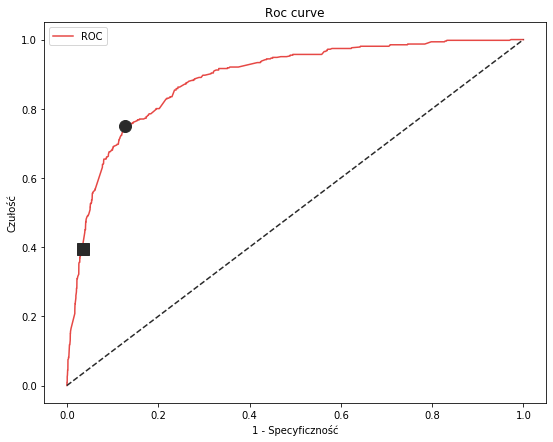

In [112]:
plot_roc_curve(fpr, tpr, 'Roc curve')

In [113]:
real_0 = y_test == 0
real_1 = y_test == 1

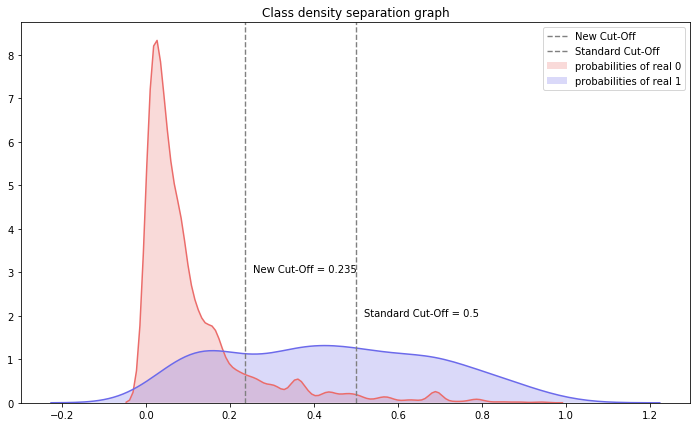

In [114]:
plt.figure(figsize = (12, 7))
#sns.set_palette()
ax_1 = sns.kdeplot(prawd_rl.loc[real_0.values], shade = True, color = '#eb6c6a')
ax_2 = sns.kdeplot(prawd_rl.loc[real_1.values], shade = True, color = '#6c6aeb')

ax_2.text(new_cut_off + 0.02, 3, 'New Cut-Off = {}'.format(new_cut_off.round(3)), )
ax_2.axvline(new_cut_off, linestyle = '--', color = 'grey', linewidth = 1.4)

ax_2.text(0.5 + 0.02, 2, 'Standard Cut-Off = {}'.format(0.5), )
ax_2.axvline(0.5, linestyle = '--', color = 'grey', linewidth = 1.4)
plt.legend(['New Cut-Off', 'Standard Cut-Off', 'probabilities of real 0', 'probabilities of real 1'])
plt.title('Class density separation graph')
plt.show()

# assumptions
# if the customer takes a loan and repays it, the bank will earn 18%,
# In the case of default, 75 % loss
.

In [115]:
def find_cut_off(cut_off):
    loan_amount =pd.concat([test[['app_loan_amount', 'default12']],prawd_rl > cut_off], axis = 1)
    loan_amount.columns =  ['app_loan_amount', 'default12', "default_predict"]
    loan_amount['default_predict'] = loan_amount['default_predict'].map(lambda x: int(x))

    loan_amount['Zyks'] = loan_amount.apply(lambda x: x['app_loan_amount'] * 0.18 if x['default12'] == x['default_predict'] == 0 else 0, axis = 1)
    loan_amount['Zyks'] = loan_amount.apply(lambda x: x['app_loan_amount'] *- 0.75 if x['default12'] == 1 and x['default_predict'] == 0 else x['Zyks'] , axis = 1)
    loan_amount['matrix'] = loan_amount.apply(lambda x: "TP" if x['default12'] == x['default_predict'] == 0 else "0", axis = 1)
    loan_amount['matrix'] = loan_amount.apply(lambda x: "FN" if x['default12'] == 1 and x['default_predict'] == 0 else x['matrix'] , axis = 1)
    return loan_amount[loan_amount['matrix'] != "0"]['Zyks'].sum()


In [156]:
wyniki = {}
for cut in np.arange(0, 1.01, 0.01):
    wyniki[cut] = find_cut_off(cut)
    
wyniki = pd.Series(wyniki)

In [157]:
wyniki.head()

0.00          0.00
0.01     274363.20
0.02     574992.00
0.03     846351.72
0.04    1102356.00
dtype: float64

In [158]:
najwyzszy_zysk = wyniki.loc[wyniki.argmax()]
najlepszy_punkt_odciecia = wyniki.loc[wyniki.argmax():wyniki.argmax()+1].index[0]
najlepszy_punkt_odciecia

0.33

In [159]:
punkty_odciecia= np.arange(0, 1.01, 0.01)

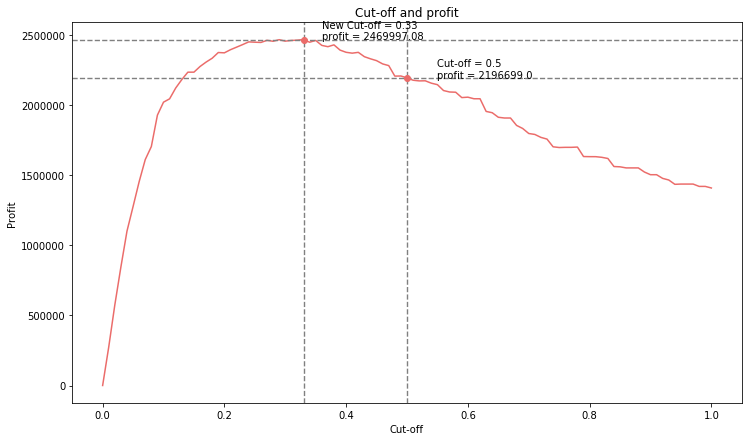

In [164]:
plt.figure(figsize = (12, 7))
ax_1 = sns.lineplot(x = punkty_odciecia, y = wyniki, color = '#eb6c6a')
ax_1.text(najlepszy_punkt_odciecia + 0.03, wyniki.loc[najlepszy_punkt_odciecia] + 1000, 'New Cut-off = {} \nprofit = {}'.format( najlepszy_punkt_odciecia,wyniki.loc[najlepszy_punkt_odciecia]))
ax_1.axvline(najlepszy_punkt_odciecia, linestyle = '--', color = 'grey', linewidth = 1.4)

ax_1.text(0.55, wyniki.loc[0.5], 'Cut-off = 0.5 \nprofit = {}'.format(round(wyniki.loc[0.5])))
ax_1.axvline(0.5, linestyle = '--', color = 'grey', linewidth = 1.4)
ax_1.axhline(wyniki.loc[0.5], linestyle = '--', color = 'grey', linewidth = 1.4)

ax_1.axhline(wyniki.loc[najlepszy_punkt_odciecia], linestyle = '--', color = 'grey', linewidth = 1.4)
ax_1.plot(0.5, wyniki.loc[0.5], "or", color = '#eb6c6a')
ax_1.plot(najlepszy_punkt_odciecia, wyniki.loc[najlepszy_punkt_odciecia], "or", color = '#eb6c6a')
ax_1.set_xlabel('Cut-off')
ax_1.set_ylabel('Profit')
plt.title('Cut-off and profit')
plt.show()

plt.show()

In [165]:
gini_defaults = []

for year in df['year'].unique():
    for default in ['default12','default9','default6', 'default3']:
        X_train = df[df['year'] ==year][np.append('intercept',featurest)]
        y_train = df_defaults[df_defaults['year'] ==year][default].fillna(0)
        prawd_rl_train = model_rl.predict(X_train)
        gini_defaults.append({"Defaults": default,
                              "Year": year,
                             "Gini": 2*roc_auc_score(y_train, prawd_rl_train)-1})
     

gini_defaults = pd.DataFrame(gini_defaults)

# Model stability

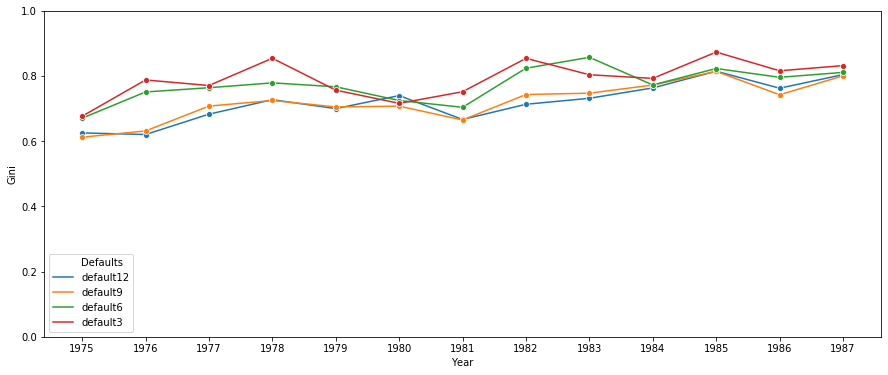

In [166]:
plt.figure(figsize = (15,6))
plt.ylim(0.0, 1)
sns.lineplot(x='Year', y ='Gini', data =gini_defaults, hue='Defaults', marker="o" );

In [167]:
statistic['Condition'] = statistic.apply(lambda x: x['Max'] if x['Max'] ==x['Min']  else x["Condition"], axis = 1)
statistic['Condition'] = statistic.apply(lambda x: "missing" if str(x['Max']) == "nan"  else x["Condition"], axis = 1)

In [168]:
statistic['Feature']= statistic['Feature'].map(lambda x: x+"_Logit")

In [169]:
to_score = statistic.loc[statistic['Feature'].isin(featurest)][['Feature','Value','Condition','WoE','Logit']]
fn = to_score.groupby('Feature')['Logit'].max().to_dict()
model_parm = model_rl.params.to_dict()
to_score['Beta'] = to_score['Feature'].map(model_parm)

fn = to_score.groupby(['Feature','Beta'])['Logit'].max().to_frame().reset_index()
fn['fn'] = fn['Beta'] * fn['Logit']
fn['alp'] = fn['Beta'] * fn['Logit'] * 20/np.log(2)
fn['alp'] = - fn['alp'].sum() + 300

to_score = to_score.merge(fn[['Feature','fn','alp']], on='Feature')

In [170]:
to_score['alpha'] = model_rl.params[0]
to_score['n_features'] = model_rl.params.shape[0]-1
to_score['factor'] = 20/np.log(2)

In [171]:
to_score['Scorecard_points'] = round((-(to_score.Logit*to_score.Beta) + to_score.fn - to_score.alpha/to_score.n_features)*to_score.factor+to_score.alp/to_score.n_features)

In [172]:
df['period'] = df['period'].map(lambda x: str(x))
df['year'] = df['period'].map(lambda x: str(x[:4]))
df['year'] = df['year'].map(lambda x: int(x))

In [173]:
featurest = [x.replace("_Logit","") for x in featurest]

In [174]:
lst_ = []
for year in df['year'].unique():
    dataset = df[df.year == year]
    for feat in featurest:
        for i in range(dataset[feat].nunique()):
            val = list(dataset[feat].unique())[i]


            lst_.append({
                "Year" : year,
                "Feat": feat,
                'Value': val,
                'N': dataset[dataset[feat] == val].count()[feat],
                'Good': dataset[(dataset[feat] == val) & (dataset['default12'] == 0)].count()[feat],
                'Bad': dataset[(dataset[feat] == val) & (dataset['default12'] == 1)].count()[feat],
                "Average_balance": round(dataset[(dataset[feat] == val)]['app_loan_amount'].mean())
            })
        dset = pd.DataFrame(lst_)
        dset['Bad_rate'] = round((dset['Bad'] / dset['N'])*100,2)
        dset['Percante_of_population'] = round((dset['N'] / dset['N'].sum())*100,2)
        dset['Distr_Good'] = round(dset['Good'] / dset['Good'].sum(),2)
        dset['Distr_Bad'] = round(dset['Bad'] / dset['Bad'].sum(),2)
        dset = dset.sort_values(by='Year')
            
       


In [179]:
def d3_graph(df,what):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle(what, fontsize=16)
    ax1 = fig.add_subplot(111, projection='3d')

    for i,numer in enumerate( sorted(df.Year.unique(),reverse = False) ):    
        dset = df[df.Year == numer]
        
        
        locator = FixedLocator([1,2,3,4,5,6,7,8,9,10])
        


        xpos = dset['Year']
        ypos = dset['Value']

        num_elements = len(dset['Value'])
        zpos = np.zeros(num_elements)

        dx = np.ones(num_elements)* 0.6
        dy = np.ones(num_elements)* 0.3
        colors = ["b","g","r","c","m","y","k","w","b","g","r","c","m","y","k","w"]

        dz = dset[what]

        ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors[i], alpha = 0.8 ,shade = True )
        ax1.view_init(elev = 10,azim=15)
        ax1.set_xlabel('Years')
        ax1.set_ylabel('GRP')
        ax1.set_zlabel(what)
        ax1.yaxis.set_major_locator(locator)
        

    plt.show()
    


In [180]:
def stat_feature(feat):
    print ('\033[1m' + '{}'.format(feat))
    print("******** Scorecard_points ********")
    print(to_score[to_score.Feature == feat + "_Logit"][['Value','Condition','Scorecard_points']])
    d3_graph(dset[dset.Feat == feat],'Average_balance' )
    d3_graph(dset[dset.Feat == feat],'Bad_rate' )

# Score points of feature and barcharts of Average balance and Bad rate

grp_act_call_n_loan
******** Scorecard_points ********
   Value                     Condition  Scorecard_points
4    1.0  2.0 < act_call_n_loan << 8.0              13.0
5    2.0                             1              55.0


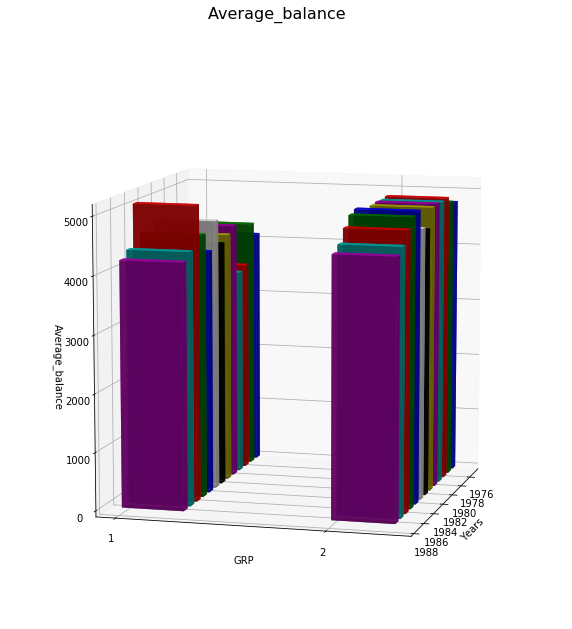

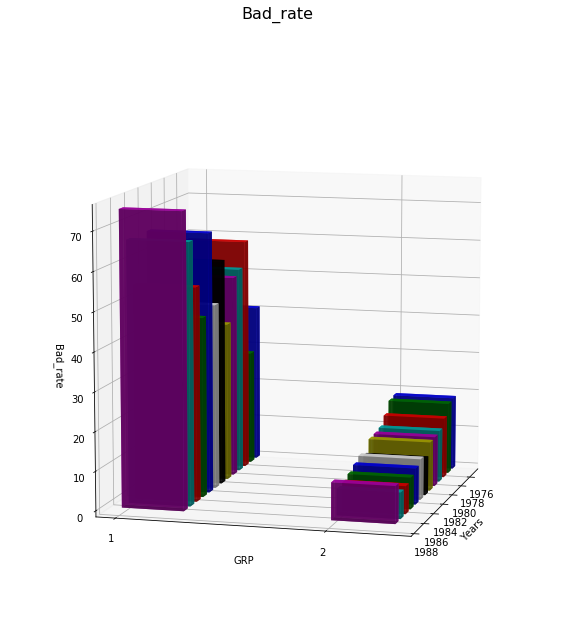

grp_act_cc
******** Scorecard_points ********
    Value                                          Condition  Scorecard_points
6     1.0  1.1722772277227722 < act_cc << 2.6099137931034484              13.0
7     2.0  0.8293075684380032 < act_cc << 1.1722595078299776              35.0
8     3.0  0.7523696682464455 < act_cc << 0.8292682926829268              40.0
9     4.0  0.22290232083652128 < act_cc << 0.752244165170...              44.0
10    5.0  0.03261652433377919 < act_cc << 0.222891566265...              59.0


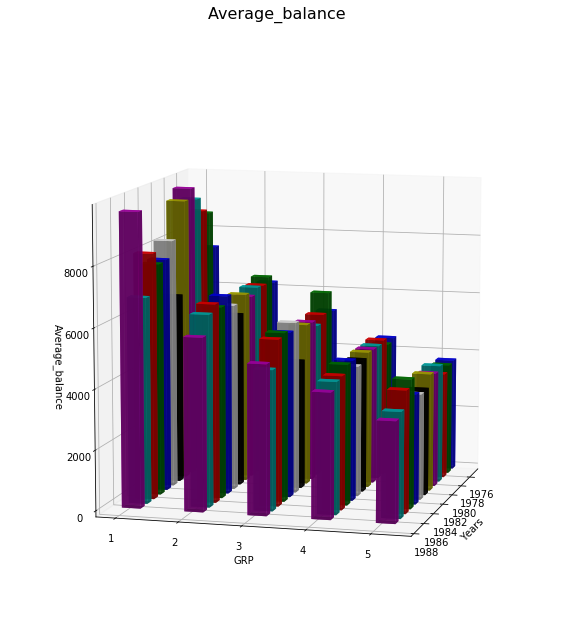

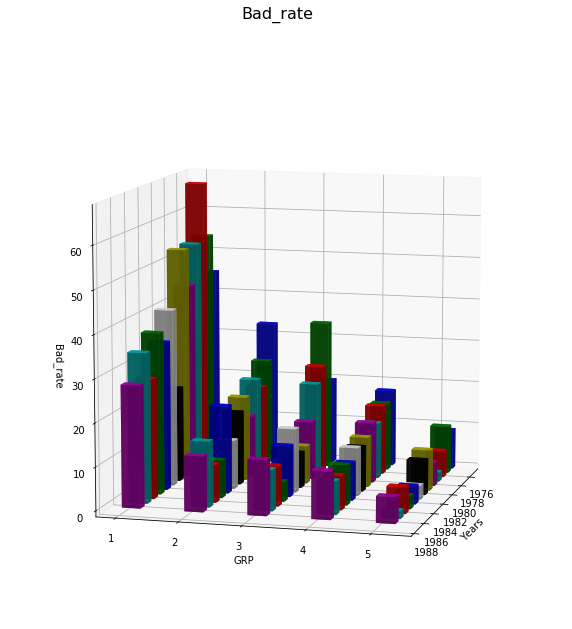

grp_act_cins_min_seniority
******** Scorecard_points ********
    Value                                Condition  Scorecard_points
11    1.0     1.0 < act_cins_min_seniority << 29.0              13.0
12    2.0                                  missing              50.0
13    3.0    30.0 < act_cins_min_seniority << 53.0              60.0
14    4.0   54.0 < act_cins_min_seniority << 139.0              78.0
15    5.0  140.0 < act_cins_min_seniority << 207.0              92.0


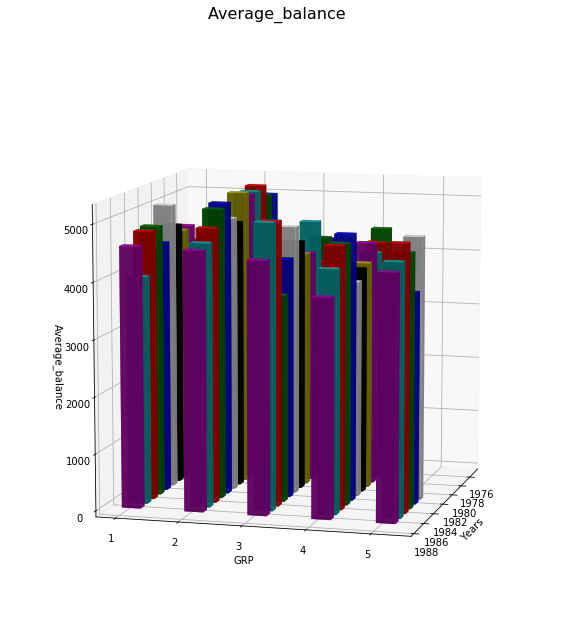

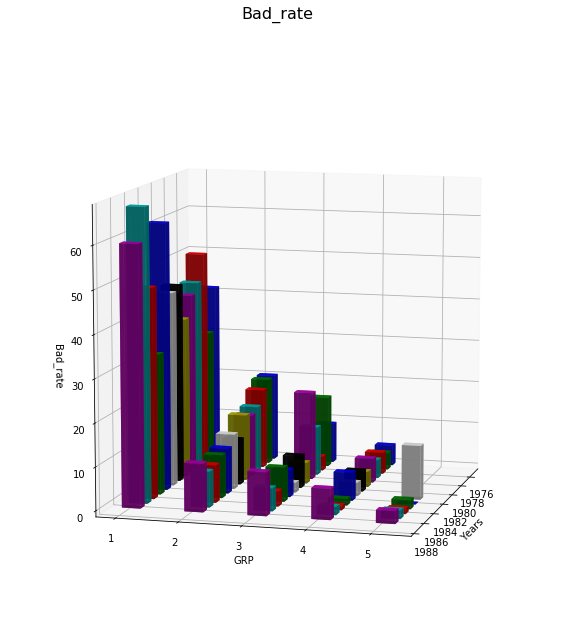

grp_act_loaninc
******** Scorecard_points ********
    Value                                          Condition  Scorecard_points
16    1.0  15.80281690140845 < act_loaninc << 65.07255520...              13.0
17    2.0  7.856777493606138 < act_loaninc << 15.79964221...              51.0
18    3.0  5.496774193548387 < act_loaninc << 7.852427184...              65.0
19    4.0  0.07708508845829823 < act_loaninc << 0.3889479...              71.0
20    5.0  2.568152866242038 < act_loaninc << 5.491525423...              74.0
21    6.0  0.38902743142144636 < act_loaninc << 2.5668449...              89.0


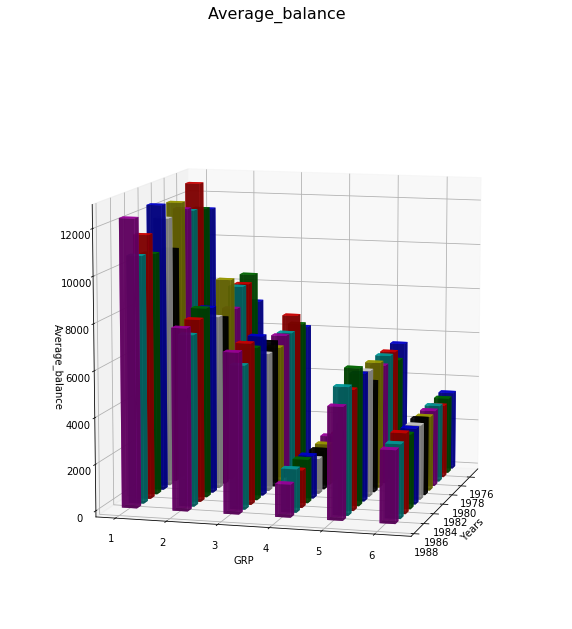

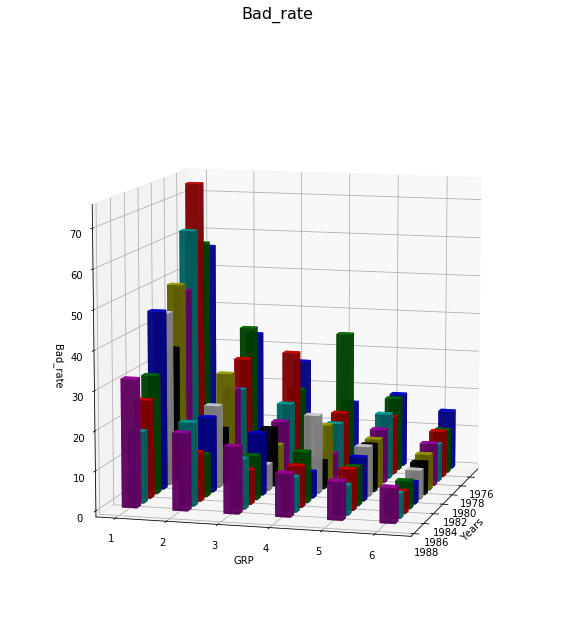

grp_app_igjm
******** Scorecard_points ********
    Value                                          Condition  Scorecard_points
22    1.0  b'Female-Contract-Divorced' < app_igjm << b'Ma...              13.0
23    2.0  b'Male-Owner company-Maried' < app_igjm << b'M...              45.0
24    3.0  b'Female-Permanent-Divorced' < app_igjm << b'M...              57.0
25    4.0  b'Female-Owner company-Maried' < app_igjm << b...              65.0
26    5.0                           b'Female-Retired-Maried'              77.0
27    6.0                         b'Female-Permanent-Maried'              87.0


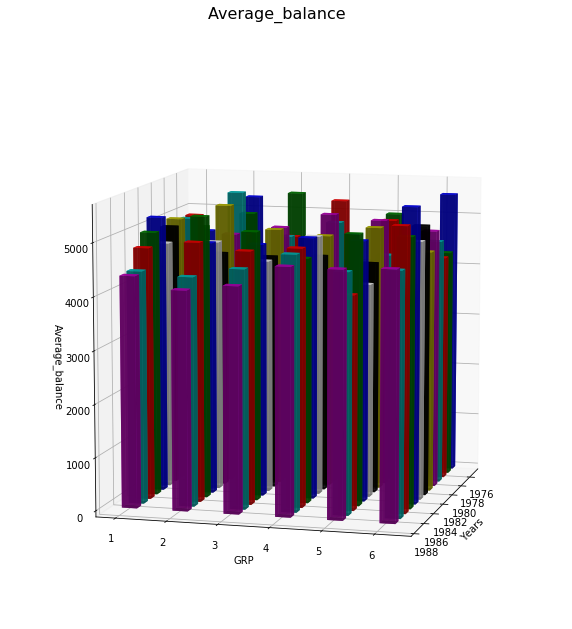

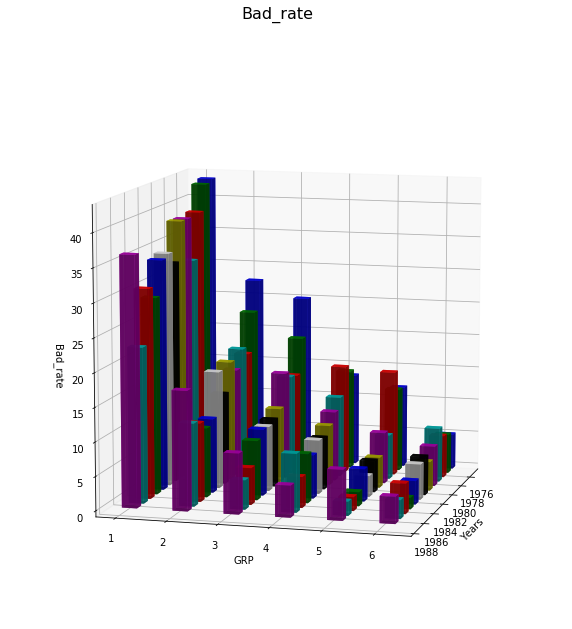

grp_app_number_of_children
******** Scorecard_points ********
    Value                            Condition  Scorecard_points
28    1.0                                    0              13.0
29    2.0                                    1              42.0
30    3.0  2.0 < app_number_of_children << 3.0              93.0


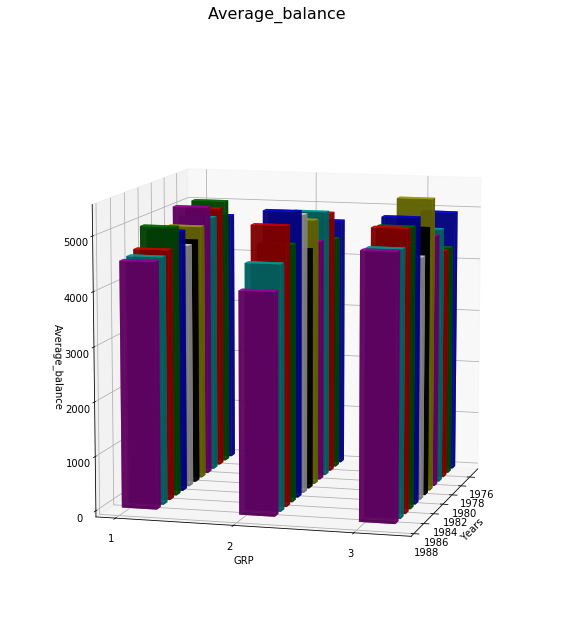

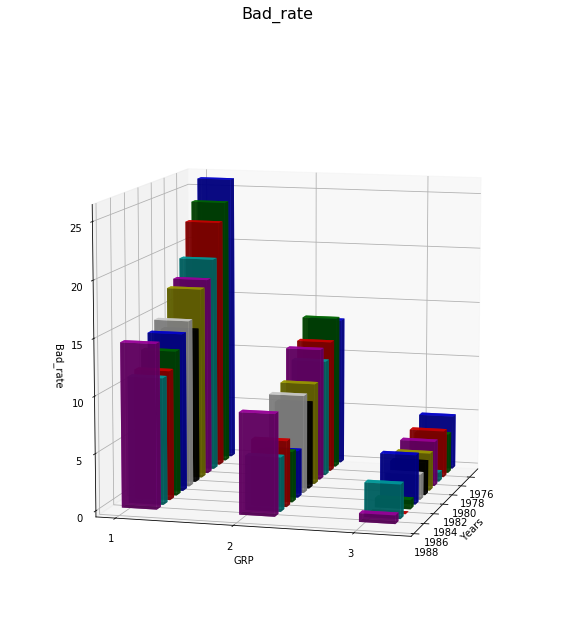

grp_act_age
******** Scorecard_points ********
   Value               Condition  Scorecard_points
0    1.0  20.0 < act_age << 45.0              13.0
1    2.0  46.0 < act_age << 60.0              53.0
2    3.0  61.0 < act_age << 75.0              76.0
3    4.0  76.0 < act_age << 92.0              80.0


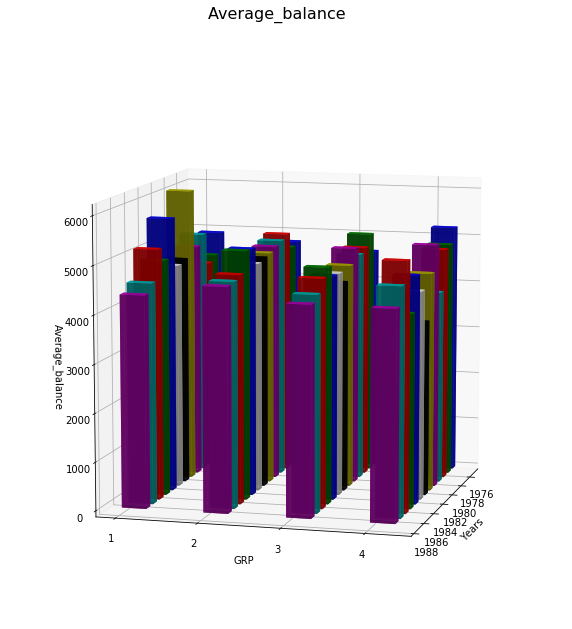

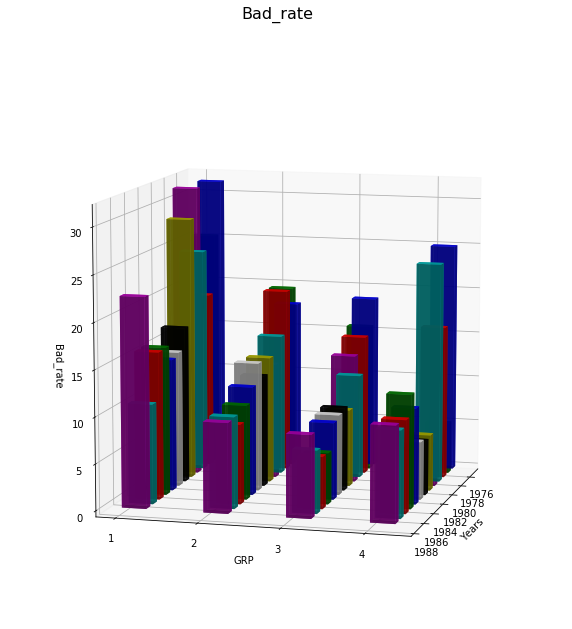

In [181]:
for feat in featurest:
    stat_feature(feat)


### Gini statistics for features in the model 

In [182]:
preselection.loc[preselection['Zmienna'].isin([x + "_Logit" for x in featurest] )][['Zmienna','Gini_test']].sort_values("Gini_test", ascending= False)

,Zmienna,Gini_test
195,grp_app_igjm_Logit,0.421
34,grp_act_cins_min_seniority_Logit,0.303
43,grp_act_loaninc_Logit,0.231
199,grp_app_number_of_children_Logit,0.224
14,grp_act_call_n_loan_Logit,0.187
15,grp_act_cc_Logit,0.145


In [183]:
scale_points = to_score.groupby('Feature')['Scorecard_points'].agg({"Minimum of scorecard points": min,
                                                    "Maximum of scorecard points": max})

In [184]:
scale_points['Range'] = scale_points["Maximum of scorecard points"] - scale_points["Minimum of scorecard points"]
scale_points['Part of global range'] = scale_points['Range'] / scale_points['Range'].sum()

### Scale of features scorecard points

In [185]:
scale_points.sort_values("Range", ascending =False)

,Minimum of scorecard points,Maximum of scorecard points,Range,Part of global range
Feature,,,,
grp_app_number_of_children_Logit,13.0,93.0,80.0,0.172414
grp_act_cins_min_seniority_Logit,13.0,92.0,79.0,0.170259
grp_act_loaninc_Logit,13.0,89.0,76.0,0.163793
grp_app_igjm_Logit,13.0,87.0,74.0,0.159483
grp_act_age_Logit,13.0,80.0,67.0,0.144397
grp_act_cc_Logit,13.0,59.0,46.0,0.099138
grp_act_call_n_loan_Logit,13.0,55.0,42.0,0.090517
